# 🏞️ **From Waves to Images: Our First Radar Image!**

It’s time to **put everything we’ve learned so far together**! 🎯  

🌊 Imagine our **beloved buoy array** floating on a peaceful lake. We **transmit a short pulse** of waves by forcefully pushing the buoys down all at once, creating a strong **wavefront**.  

🏔️ Now, let’s say **a massive rocky cliff** stands in the distance. This cliff **reflects our wave pulse**, sending the wave back toward us.  

⏳ We’re paying close attention, and we measure the **time delay** between transmitting the wave and receiving the reflection. That is, we record the **wave height** as a time series at each buoy location.  

📡 As the **reflected wavefront** reaches our array, the buoys begin to **wiggle**—but not all at the same time! Since the cliff **isn’t directly ahead**, the wavefront **arrives at an angle**, introducing a slight delay between buoys.  

This is exactly how **radar echoes arrive at an antenna array**—now let’s see how we can process them! 🚀✨  

/mnt/c/Users/ZacharyDethloff/Documents/GitHub/mission_ops/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


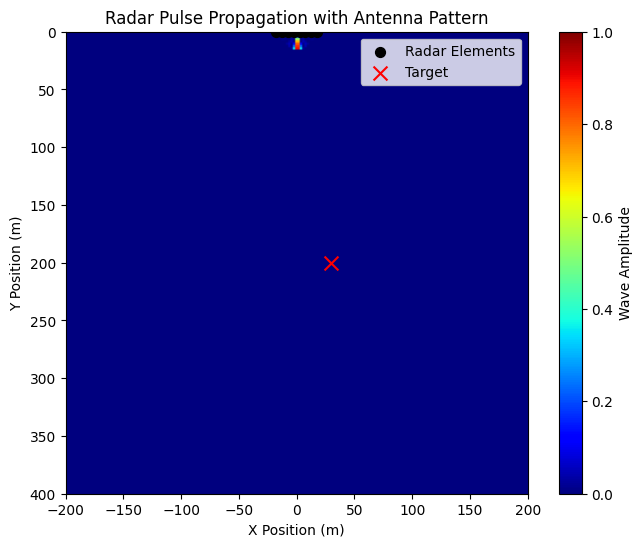

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

# Constants
c = 3e8  # Speed of light (m/s)
wavelength = 10.0  # Wavelength (meters)
carrier_freq = 0.0  # Carrier frequency
pulse_duration = 5e-8  # Pulse duration (seconds)
grid_size = 200  # Grid resolution
space_extent = 20 * wavelength  # Spatial extent in x and y directions
num_frames = 100  # Number of animation frames
total_time = 4 * space_extent / c  # Total simulation time

# Create a meshgrid for the 2D space
x = np.linspace(-space_extent, space_extent, grid_size)
y = np.linspace(0, 2 * space_extent, grid_size)
X, Y = np.meshgrid(x, y)

# Radar and Target Configuration
N = 8  # Number of antenna elements in the radar array
d = wavelength / 2  # Half-wavelength element spacing
positions = np.linspace(-(N-1)/2 * d, (N-1)/2 * d, N)

# Define the target location
target_x, target_y = 30, 200  # Target position
target_range = np.sqrt(target_x**2 + target_y**2)
target_angle = np.arctan2(target_x, target_y)

# Define the antenna pattern (simple sinc function for main lobe)
def antenna_pattern(theta):
    """
    Simulated antenna pattern (approximated by a sinc function).
    """
    return np.sinc(N * np.sin(theta) / np.pi) ** 2  # Normalized pattern

def radar_pulse(R_arr, R_t, current_time, pulse_duration, target_range, amplitude, theta):
    """
    Generates a radar pulse traveling toward a target and reflecting back.
    """
    target_pulse = np.zeros_like(R_t)
    outgoing_pulse = np.zeros_like(R_arr)
    pulse_distance = current_time * c + (pulse_duration / 2) * c
    pulse_width = pulse_duration * c  # Physical pulse width in m

    # outgoing_pulse
    in_pulse_out = (R_arr > pulse_distance - pulse_width / 2) & (R_arr < pulse_distance + pulse_width / 2)
    in_pulse_target = []
    if target_range - pulse_width / 2 <= pulse_distance:
        pulse_range = pulse_distance - target_range
        in_pulse_target = (R_t < pulse_range + pulse_width / 2) & (R_t > pulse_range - pulse_width / 2)

    # The outgoing pulse is there always
    if np.any(in_pulse_out):
        r_pulse_outgoing = R_arr[in_pulse_out]
        outgoing_pulse[in_pulse_out] = np.cos(2 * np.pi * carrier_freq * ((r_pulse_outgoing - r_pulse_outgoing[0]) / c))

    if np.any(in_pulse_target):
        r_pulse = R_t[in_pulse_target]
        target_pulse[in_pulse_target] = np.cos(2 * np.pi * carrier_freq * ((r_pulse - r_pulse[0]) / c))

    # Multiply by antenna pattern
    return outgoing_pulse * antenna_pattern(theta) + amplitude*target_pulse*antenna_pattern(target_angle)

# Initialize figure
fig, ax = plt.subplots(figsize=(8, 6))
extent = (-space_extent, space_extent, 2 * space_extent, 0)
cax = ax.imshow(np.zeros_like(X), extent=extent, cmap='jet', vmin=0, vmax=1, animated=True)
plt.colorbar(cax, ax=ax, label='Wave Amplitude')
ax.set_title("Radar Pulse Propagation with Antenna Pattern")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")

# Plot radar array and target
ax.scatter(positions, np.zeros_like(positions), color="black", s=50, marker='o', label="Radar Elements")
ax.scatter(target_x, target_y, color="red", s=100, marker="x", label="Target")
ax.legend()

# Animation update function
def update(frame):
    current_time = frame * total_time / num_frames
    Z_total = np.zeros_like(X)

    # Outgoing wave from the radar array with directional pattern
    R_array = np.sqrt(X**2 + Y**2) # range from each array element
    R_target = np.sqrt((X - target_x)**2 + (Y-target_y)**2) # range from target
    theta = np.arctan2(X, Y)  # Compute angle for antenna pattern
    Z_total += radar_pulse(R_array, R_target, current_time, pulse_duration, target_range, amplitude=0.1, theta=theta)

    cax.set_array(Z_total)
    return cax,

# Create animation
mapping_animation = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=False)
display(HTML(mapping_animation.to_jshtml()))

## 🔎 **Detecting the Cliff’s Location**

We now have the **range**—the **radial distance**—simply by measuring **the wave height as a function of time delay** from the returning wave. 🌊⏳  

But what about the **azimuth angle**? 🤔  

🏔️ We have **recorded how each buoy moved** up and down as the wavefront arrived. 

To process our measurements, we **arrange the received data into an array**: 🔢

📡 The **first row** represents the **wave height vs. time** as measured by the **first buoy**.  
🌊 The **second row** contains the **signal from the second buoy**, and so on for the rest of the array.  

This structured format allows us to analyze how the wavefront **arrives at each buoy over time**, setting the stage for extracting both **range and angle information** in the form of a **2D image**!  🏞️

Once we have gathered all the echo data, we can perform an **angular scan** across the entire **front sector**—just like we did in the last notebook! 🔍🎯  

This is how we transition from **raw wave measurements** to **mapping the environment**—one step closer to real radar processing! 🚀✨  

## 📡 **Scanning the Environment**
Since we’ve recorded signals at **multiple ranges** (time delays), we can perform this scan **for each range sample (also called a range bin 🗑️) of the receiced signal**:

1. We collect the recorded **phasors** from all buoy elements. ↗️↖️↗️↖️
2. **We scan** by adjusting each element’s phase shift according to the **azimuth angle**. (I.e. the direction where we want to focus our gaze). ↗️✖️↖️
3. **Summing the phase-adjuseted signals** together gives us the response at that azimuth angle.↗️➕↗️➕↗️➕↗️
4. Repeat the phase adjustment for **each azimuth angle** we want to map. 🔁 
5. We place the resulting beamforming output as a column of our **range-azimuth** 2D image. 🔢

We’ve just mapped our **environment in range and azimuth angle**—allowing us to **plot the reflected wave energy** at different positions as a **2D image**! 🎉

## 🎛️ Experiment: Simulating Echoes and Forming a Radar Image  

🔬 Experiment with the code below, where we **simulate echoes from two targets** using a **phased array** and a **single transmitted wave pulse**.  

📡 After capturing the returning echoed signals, we **combine the echoes** to form a **radar image**—**voilà!** 🎉  

Try it out and see how the targets appear! 🚀✨  

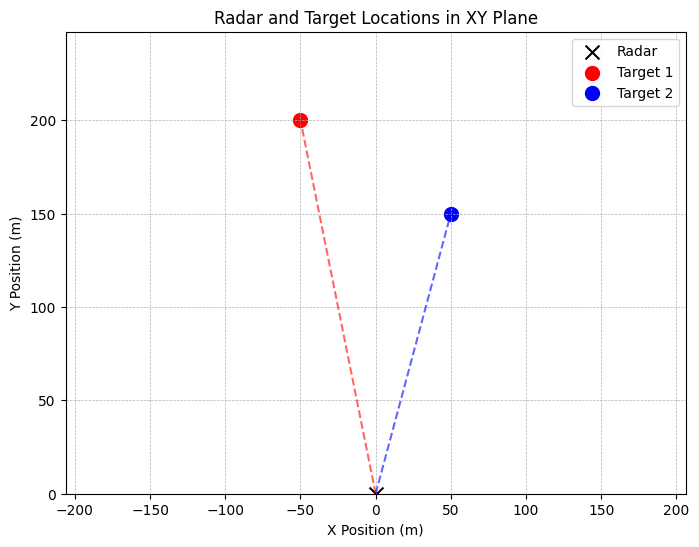

[[ 0.75581415+0.6547862j ]
 [-0.42231979-0.90644691j]
 [ 0.01510883+0.99988586j]
 [ 0.39473941-0.91879312j]
 [-0.73568524+0.67732358j]
 [ 0.94821604-0.31762611j]
 [-0.9952342 -0.0975135j ]
 [ 0.86853264+0.49563197j]
 [-0.59022732-0.80723709j]
 [ 0.20889687+0.97793768j]
 [ 0.20889687-0.97793768j]
 [-0.59022732+0.80723709j]
 [ 0.86853264-0.49563197j]
 [-0.9952342 +0.0975135j ]
 [ 0.94821604+0.31762611j]
 [-0.73568524-0.67732358j]
 [ 0.39473941+0.91879312j]
 [ 0.01510883-0.99988586j]
 [-0.42231979+0.90644691j]
 [ 0.75581415-0.6547862j ]]


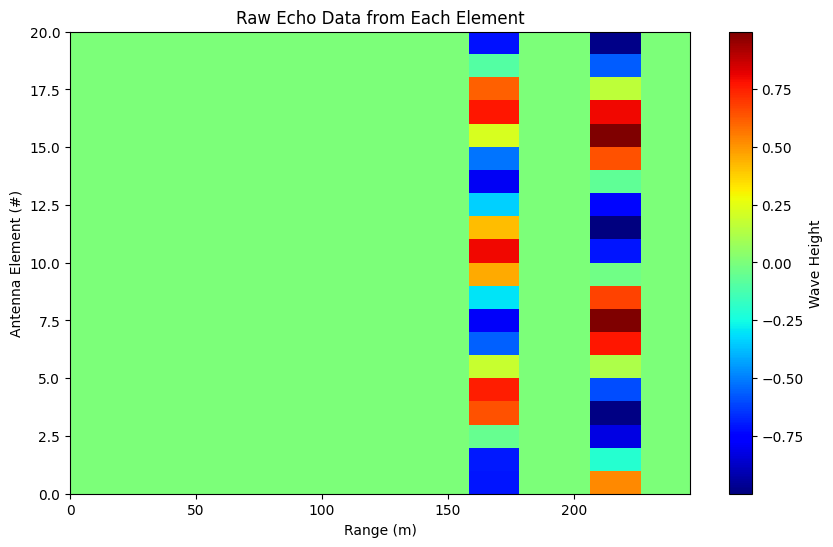

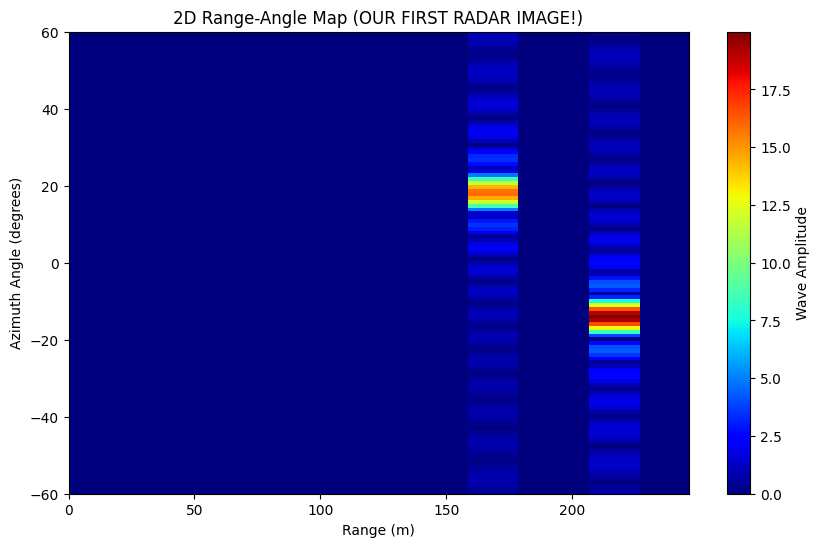

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8  # Speed of light (m/s)

# User-defined parameters
range_resolution = 20  # meters
pulse_duration = 2 * range_resolution / c  # pulse duration [s]
sampling_rate = 10 / pulse_duration  # We take 10 samples per pulse
wavelength = 0.03  # Radar wavelength (3 cm)
number_of_elements = 20  # Number of antenna elements

# Define targets (xy locations in meters, amplitude)
target1_x, target1_y = -50, 200
target2_x, target2_y = 50, 150
target_amplitudes = [1, 0.8]

# Calculate target ranges and angles
target_ranges = [np.sqrt(target1_x**2 + target1_y**2), np.sqrt(target2_x**2 + target2_y**2)]
max_range = np.max(target_ranges)
total_time = 2 * max_range / c + 2 * pulse_duration  # Ensure enough time for full echoes
angle1_rad = np.arctan2(target1_x, target1_y)
angle2_rad = np.arctan2(target2_x, target2_y)
target_angles = [angle1_rad, angle2_rad]

# Plot the target locations and radar position on the XY plane
fig, ax = plt.subplots(figsize=(8, 6))

# Plot radar position at origin
ax.scatter(0, 0, color='black', marker='x', s=100, label="Radar")

# Plot targets
ax.scatter(target1_x, target1_y, color='red', s=100, label="Target 1")
ax.scatter(target2_x, target2_y, color='blue', s=100, label="Target 2")

# Draw lines indicating the wave propagation path
ax.plot([0, target1_x], [0, target1_y], 'r--', alpha=0.6)
ax.plot([0, target2_x], [0, target2_y], 'b--', alpha=0.6)

# Formatting the plot
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_title("Radar and Target Locations in XY Plane")
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_xlim(-max_range, max_range)
ax.set_ylim(0, max_range * 1.2)

plt.show()

def generate_target_echoes(pulse_duration, targets, angles, sampling_rate, total_time, amplitudes, wavelength, number_of_elements):
    """
    Simulates the received radar pulses for each element in an antenna array, 
    incorporating both range delays and phase shifts due to azimuth angle.
    """
    num_samples = int(total_time * sampling_rate)
    t = np.linspace(0, total_time, num_samples, endpoint=False)
    k = 2 * np.pi / wavelength
    
    # Define the antenna array element positions (Uniform Linear Array)
    d = wavelength / 2  # Element spacing (half-wavelength spacing)
    positions = np.linspace(-(number_of_elements-1)/2 * d, (number_of_elements-1)/2 * d, number_of_elements)

    # Initialize signal array (each row is an antenna element)
    received_signals = np.zeros((number_of_elements, num_samples), dtype=np.complex64)

    for i, (target_range, target_angle) in enumerate(zip(targets, angles)):
        # Compute time delay for round-trip echo
        round_trip_time = 2 * target_range / c  # Time delay for the pulse to reach & return

        # Compute index range for pulse in time vector
        pulse_start_idx = int(round_trip_time * sampling_rate)
        pulse_end_idx = pulse_start_idx + int(pulse_duration * sampling_rate)

        # Compute phase shift for each array element
        target_phasor = np.exp(1j * 2 * np.pi * 2 * target_range / wavelength)  # Phase from range
        phase_shifts = np.exp(1j * k * positions * np.sin(target_angle))  # Phase shift per array element due to target angle
        
        # Ensure pulse fits within signal array
        if pulse_end_idx < num_samples:
            pulse = np.ones(pulse_end_idx - pulse_start_idx)  # Simple rectangular pulse
            
            # Apply phase shifts for each antenna element and target phase due to range
            for e in range(number_of_elements):
                received_signals[e, pulse_start_idx:pulse_end_idx] += (
                    pulse * amplitudes[i] * target_phasor * phase_shifts[e]
                )

    return t, received_signals

# Run simulation
t, received_signals = generate_target_echoes(
    pulse_duration, target_ranges, target_angles, sampling_rate, total_time, target_amplitudes, wavelength, number_of_elements
)

# Define beamforming parameters
angle_min = -60  # Minimum scan angle (degrees)
angle_max = 60   # Maximum scan angle (degrees)
angle_step = 1   # Angle spacing (degrees)

scan_angles = np.arange(angle_min, angle_max + angle_step, angle_step)  # Beamforming angles
num_ranges = received_signals.shape[1]  # Number of time samples (range bins)

# Compute beamformed response
beam_output = np.zeros((len(scan_angles), num_ranges), dtype=np.complex64)
k = 2 * np.pi / wavelength
d = wavelength / 2
positions = np.linspace(-(number_of_elements-1)/2 * d, (number_of_elements-1)/2 * d, number_of_elements)

# Perform azimuth beamforming scan over the defined angles
for i, scan_angle in enumerate(scan_angles):
    scan_phase_shifts = np.exp(-1j * k * positions * np.sin(np.radians(scan_angle)))
    beam_output[i, :] = np.sum(received_signals * scan_phase_shifts[:, None], axis=0)


# Plot the 2D Data Array
plt.figure(figsize=(10, 6))
extent = [0, total_time * c / 2, 0, number_of_elements]  # Time mapped to range
plt.imshow(np.real(received_signals), aspect='auto', extent=extent, cmap='jet', origin='lower')
plt.colorbar(label="Wave Height")
plt.xlabel("Range (m)")
plt.ylabel("Antenna Element (#)")
plt.title("Raw Echo Data from Each Element")
plt.show()

# Plot the 2D Range-Angle Map
plt.figure(figsize=(10, 6))
extent = [0, total_time * c / 2, angle_min, angle_max]  # Time mapped to range
plt.imshow(np.abs(beam_output), aspect='auto', extent=extent, cmap='jet', origin='lower')
plt.colorbar(label="Wave Amplitude")
plt.xlabel("Range (m)")
plt.ylabel("Azimuth Angle (degrees)")
plt.title("2D Range-Angle Map (OUR FIRST RADAR IMAGE!)")
plt.show()

## 🎨 **Our First Radar Image!**

We’ve just created **our first 2D radar image**! 🎊

- **🔍 Angular resolution** depends on **the width of our array**.  
- **📏 Range resolution** is determined by **our pulse duration**.  

Now, here’s a little secret: **you’ve just learned the core principles of radar imaging!** 🎉  

The fundamental **physics and signal processing** behind **Synthetic Aperture Radar (SAR)** are **nothing more than this**. The only difference? We use a few **clever tricks** to boost **resolution and signal power**. 🛠️✨  

But that’s a lesson for next time. If you’ve followed along and understood how this works, **you’re already most of the way there!** 🚀 